In [1]:
#import necessary packages
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

#load datafram
df = pd.read_csv("Reviews.csv")

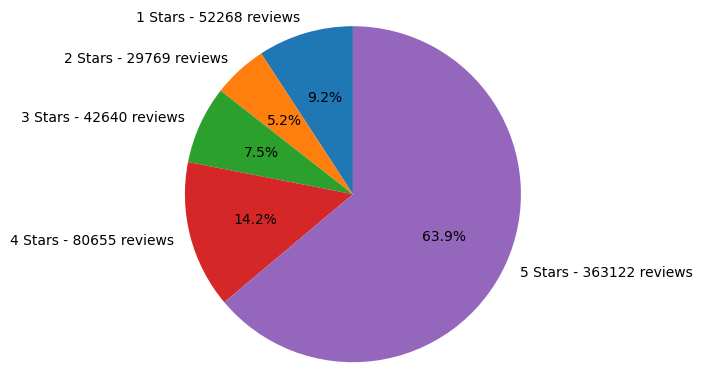

In [2]:
import matplotlib.pyplot as plt
# count of total reviews by percentages

counts = df['Score'].value_counts().sort_index()
plt.pie(counts, labels=[f"{star} Stars - {counts[star]} reviews" for star in counts.index], autopct='%1.1f%%', startangle=90)
    
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()

### Get the overall sentiment of the data

In [3]:
# df['sentiment'] = df['Score'].apply(lambda score: 'positive' if score > 3 else ('neutral' if score == 3 else 'negative'))
df['sentiment'] = df['Score'].apply(lambda score: 
    'very negative' if score == 1 else
    'negative' if score == 2 else
    'neutral' if score == 3 else
    'positive' if score == 4 else
    'very positive' if score == 5 else 'unknown'
)
print(df['sentiment'])


0         very positive
1         very negative
2              positive
3              negative
4         very positive
              ...      
568449    very positive
568450         negative
568451    very positive
568452    very positive
568453    very positive
Name: sentiment, Length: 568454, dtype: object


### Preproccess the text

In [4]:
# Download NLTK stopwords and initialize the stemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if isinstance(text, str) and len(text) > 0:
        text = text.lower()
        #tokenize the text
        tokens = nltk.word_tokenize(text, preserve_line=True)
        tokens = [word for word in tokens if word.isalnum()]
        #remove stop words and apply the stemmer
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        # Join tokens back into a string
        text = ' '.join(tokens)
        
        return text
    else:
        return ""

[nltk_data] Downloading package stopwords to C:\Users\Tom
[nltk_data]     O'Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import os
from tqdm import tqdm
if os.path.exists('cleaned_dataframe.csv'):
    df = pd.read_csv('cleaned_dataframe.csv')
else:
    tqdm.pandas()
    #apply preprocessing to text
    df['cleaned_reviews'] = df['Text'].progress_apply(preprocess_text)
    df.to_csv('cleaned_dataframe.csv', index=False)


In [6]:
import numpy as np
np.random.seed(42)
# Set the number of data points you want to randomly select
num_samples = 400000

# Generate random indices
# random_indices = np.random.choice(len(df), num_samples, replace=False)
X = df['cleaned_reviews']#[random_indices]
y = df['Score']#[random_indices]
#split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
len(X_train), len(y_train), len(X_test), len(y_test)

(454763, 454763, 113691, 113691)

### Convert the text into numbers

In [7]:
import torch
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

### Vectorize data

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Make model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
class SentimentAnalysisModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentAnalysisModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x


### Make DataLoader

In [10]:
from torch.utils.data import DataLoader, TensorDataset
train_data = TensorDataset(torch.from_numpy(X_train_tfidf.toarray()).float(), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = TensorDataset(torch.from_numpy(X_test_tfidf.toarray()).float(), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
input_size = 5000
hidden_size = 128
#Make outputs for different star ratings 
output_size = 6
model = SentimentAnalysisModel(input_size, hidden_size, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Train and test the model

In [12]:
from sklearn.metrics import f1_score
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    train_predictions = []
    train_true_labels = []
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device, dtype=torch.long)
        y_pred = model(X)
        torch.cuda.empty_cache()
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.cuda.empty_cache()
        optimizer.step()
        train_loss += loss.item()
        #get prediction label from number
        y_pred_class = torch.argmax(y_pred, dim=1)
        #calc acc
        train_acc += ((y_pred_class == y).sum().item()/len(y_pred))
        #collect predictions
        train_predictions.extend(y_pred_class.cpu().numpy())
        train_true_labels.extend(y.cpu().cpu().numpy())

    train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')

    model.eval() 
    # Initialize the loss and accuracy
    test_loss, test_acc = 0, 0
    test_predictions = []
    test_true_labels = []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_loader):
            # Send data to target device
            X, y = X.to(device), y.to(device, dtype=torch.long)

            # Do the testing steps
            test_pred = model(X)

            # Sum the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Sum the accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

            #collect the predictions
            test_predictions.extend(test_pred_labels.cpu().numpy())
            test_true_labels.extend(y.cpu().cpu().numpy())

    test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')

    print(f'Epoch [{epoch+1}/{num_epochs}], Train_Loss: {train_loss/len(train_loader):.4f}, Train_Acc: {train_acc/len(train_loader):.4f}, Train f1: {train_f1:.4f}, '
          f'Test_Loss: {test_loss/len(test_loader):.4f}, Test_Acc: {test_acc/len(test_loader):.4f}, Test_f1: {test_f1:.4f}')


Epoch [1/10], Train_Loss: 0.7694, Train_Acc: 0.7185, Train f1: 0.6771, Test_Loss: 0.7176, Test_Acc: 0.7379, Test_f1: 0.7075
Epoch [2/10], Train_Loss: 0.6603, Train_Acc: 0.7634, Train f1: 0.7391, Test_Loss: 0.6690, Test_Acc: 0.7630, Test_f1: 0.7388
Epoch [3/10], Train_Loss: 0.5708, Train_Acc: 0.7994, Train f1: 0.7840, Test_Loss: 0.6522, Test_Acc: 0.7757, Test_f1: 0.7551
Epoch [4/10], Train_Loss: 0.4949, Train_Acc: 0.8280, Train f1: 0.8181, Test_Loss: 0.6569, Test_Acc: 0.7810, Test_f1: 0.7689
Epoch [5/10], Train_Loss: 0.4262, Train_Acc: 0.8540, Train f1: 0.8476, Test_Loss: 0.6706, Test_Acc: 0.7866, Test_f1: 0.7757
Epoch [6/10], Train_Loss: 0.3646, Train_Acc: 0.8762, Train f1: 0.8720, Test_Loss: 0.7079, Test_Acc: 0.7827, Test_f1: 0.7764
Epoch [7/10], Train_Loss: 0.3098, Train_Acc: 0.8957, Train f1: 0.8930, Test_Loss: 0.7527, Test_Acc: 0.7859, Test_f1: 0.7788
Epoch [8/10], Train_Loss: 0.2612, Train_Acc: 0.9132, Train f1: 0.9114, Test_Loss: 0.8126, Test_Acc: 0.7815, Test_f1: 0.7771
Epoch [9

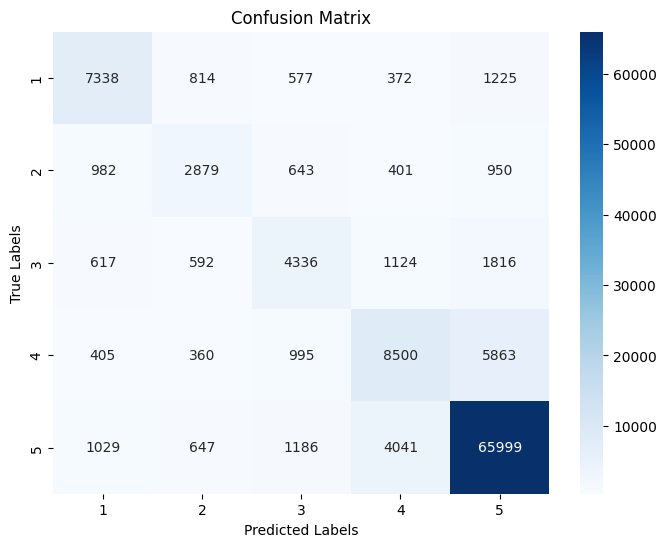

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize the lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device, dtype=torch.long)
        test_pred = model(X)
        test_pred_labels = test_pred.argmax(dim=1)

        true_labels.extend(y.cpu().cpu().numpy())
        predicted_labels.extend(test_pred_labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels = [1, 2, 3, 4, 5]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
